In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Rprop, Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# ==== DATA PREPARATION ====
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ==== MODEL DEFINITIONS ====
class RPropNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)

    def forward(self, x):
        identity = x
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return F.relu(out + identity)

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(20, 64)
        self.block1 = ResidualBlock(64)
        self.block2 = ResidualBlock(64)
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.block1(x)
        x = self.block2(x)
        return self.output(x)

class GRUNet(nn.Module):
    def __init__(self, input_size=20, hidden_size=64, num_classes=2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, seq, features)
        h0 = torch.zeros(1, x.size(0), 64)
        out, _ = self.gru(x, h0)
        return self.fc(out[:, -1, :])

# ==== TRAINING AND EVALUATION ====
def train_model(model, optimizer, loader, epochs=10):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb)
            _, preds = torch.max(out, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())
    return 1 - accuracy_score(all_labels, all_preds)

# ==== MAIN EXECUTION ====
models = {
    "RPropNN": (RPropNN(), Rprop),
    "ResNet": (ResNet(), Adam),
    "GRUNet": (GRUNet(), Adam)
}

for name, (model, Optimizer) in models.items():
    print(f"\nTraining {name}...")
    optimizer = Optimizer(model.parameters())
    train_model(model, optimizer, train_loader)
    error = evaluate_model(model, test_loader)
    print(f"{name} Classification Error: {error:.4f}")



Training RPropNN...
RPropNN Classification Error: 0.1500

Training ResNet...
ResNet Classification Error: 0.1750

Training GRUNet...
GRUNet Classification Error: 0.1300


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your brain_tumor_data.zip from your PC


Saving archive (1).zip to archive (1) (1).zip


In [ ]:
import zipfile
import os

zip_path = list(uploaded.keys())[0]  # Get the uploaded filename
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("brain_tumor_data")  # Extract to folder


In [ ]:
!ls brain_tumor_data


'Brain Tumor Data Set'	 metadata.csv   metadata_rgb_only.csv


In [ ]:
!ls -R brain_tumor_data





brain_tumor_data:
 BrainTumor		 Healthy        metadata_rgb_only.csv
'Brain Tumor Data Set'	 metadata.csv

brain_tumor_data/BrainTumor:
'Cancer (1000).jpg'  'Cancer (174).jpg'   'Cancer (304).jpg'
'Cancer (1001).jpg'  'Cancer (1750).jpg'  'Cancer (305).jpg'
'Cancer (1002).JPG'  'Cancer (1751).jpg'  'Cancer (306).jpg'
'Cancer (1003).jpg'  'Cancer (1752).jpg'  'Cancer (307).jpg'
'Cancer (1004).jpg'  'Cancer (1753).jpg'  'Cancer (308).jpg'
'Cancer (1005).jpg'  'Cancer (1754).jpg'  'Cancer (309).jpg'
'Cancer (1006).jpg'  'Cancer (1755).jpg'  'Cancer (30).jpg'
'Cancer (1007).jpg'  'Cancer (1756).jpg'  'Cancer (30).tif'
'Cancer (1008).jpg'  'Cancer (1757).jpg'  'Cancer (310).jpg'
'Cancer (1009).jpg'  'Cancer (1758).jpg'  'Cancer (311).jpg'
'Cancer (100).jpg'   'Cancer (1759).jpg'  'Cancer (312).jpg'
'Cancer (1010).jpg'  'Cancer (175).jpg'   'Cancer (313).jpg'
'Cancer (1011).jpg'  'Cancer (1760).jpg'  'Cancer (314).jpg'
'Cancer (1012).JPG'  'Cancer (1761).jpg'  'Cancer (315).jpg'
'Cancer (101

In [ ]:
!find brain_tumor_data -type d



brain_tumor_data
brain_tumor_data/Healthy
brain_tumor_data/Brain Tumor Data Set
brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set
brain_tumor_data/BrainTumor


In [ ]:
# Remove the extra folder that is causing problems
!rm -r "brain_tumor_data/Brain Tumor Data Set"


In [ ]:
!ls brain_tumor_data


BrainTumor  Healthy  metadata.csv  metadata_rgb_only.csv


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# This now works because only valid folders remain
dataset = ImageFolder("brain_tumor_data", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check class labels
print("Class mapping:", dataset.class_to_idx)

# GRUNet definition
class GRUNet(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_classes=2):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.squeeze(1)  # Remove grayscale channel
        h0 = torch.zeros(1, x.size(0), 128)
        out, _ = self.gru(x, h0)
        return self.fc(out[:, -1, :])

# Predict
model = GRUNet()
model.eval()

with torch.no_grad():
    for images, labels in dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        print("Predicted Labels:", predicted)
        break


Class mapping: {'BrainTumor': 0, 'Healthy': 1}
Predicted Labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model = GRUNet().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Increase for better performance
#loss_history = []
#acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Accuracy: {acc:.4f}")


model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Accuracy: {100 * correct / total:.2f}%")


Using device: cpu
Epoch 1/5 - Loss: 93.6506 - Accuracy: 0.6246
Epoch 2/5 - Loss: 84.5738 - Accuracy: 0.6946
Epoch 3/5 - Loss: 70.3163 - Accuracy: 0.7639
Epoch 4/5 - Loss: 51.8206 - Accuracy: 0.8500
Epoch 5/5 - Loss: 37.9070 - Accuracy: 0.9002
Final Accuracy: 92.24%


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model = GRUNet().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5  # Increase for better performance
loss_history = []
acc_history = []




for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    loss_history.append(running_loss)
    acc_history.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Accuracy: {acc:.4f}")


model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Accuracy: {100 * correct / total:.2f}%")

Using device: cpu
Epoch 1/5 - Loss: 93.5190 - Accuracy: 0.6159
Epoch 2/5 - Loss: 80.2415 - Accuracy: 0.7209
Epoch 3/5 - Loss: 65.0866 - Accuracy: 0.7967
Epoch 4/5 - Loss: 47.5541 - Accuracy: 0.8646
Epoch 5/5 - Loss: 34.9400 - Accuracy: 0.9052
Final Accuracy: 93.39%


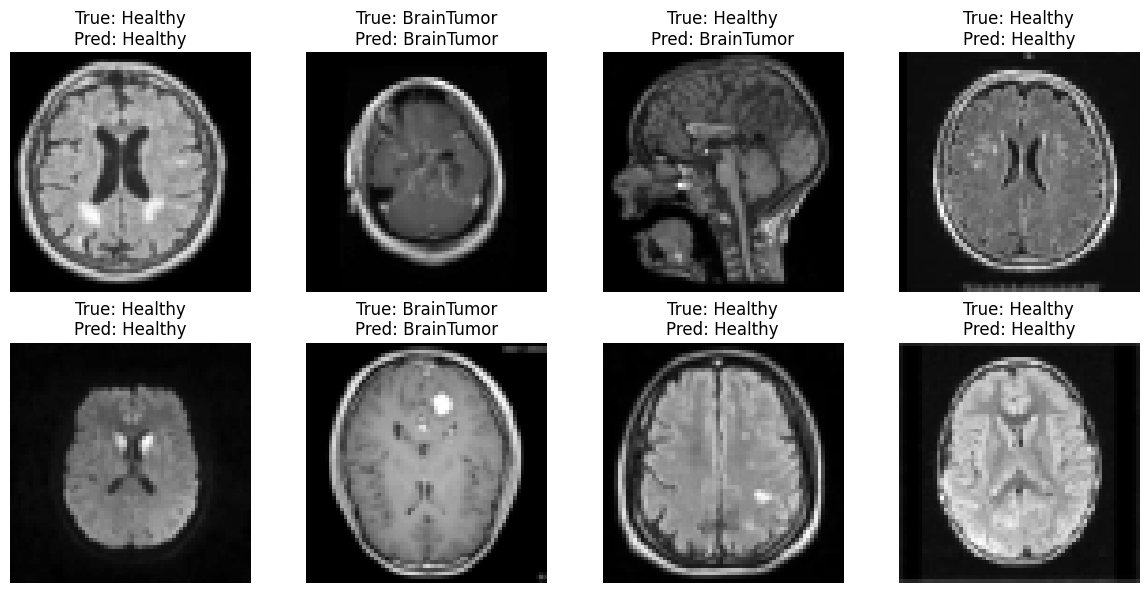

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class label mapping
class_names = dataset.classes  # ['BrainTumor', 'Healthy']

# Denormalize function
def denorm(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5  # unnormalize
    return img_tensor.squeeze().cpu().numpy()

# Get sample batch
dataiter = iter(dataloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot
plt.figure(figsize=(12, 6))
for idx in range(8):  # Show first 8 images
    plt.subplot(2, 4, idx + 1)
    plt.imshow(denorm(images[idx]), cmap='gray')  # use denorm for grayscale
    plt.title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predicted[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Save the entire model
torch.save(model.state_dict(), "trained_grunet_brain_tumor.pth")
print("Model saved as trained_grunet_brain_tumor.pth")


Model saved as trained_grunet_brain_tumor.pth


In [ ]:
from google.colab import files
files.download("trained_grunet_brain_tumor.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-29-6ccaf4cd7835>:16: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-29-6ccaf4cd7835>:16: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


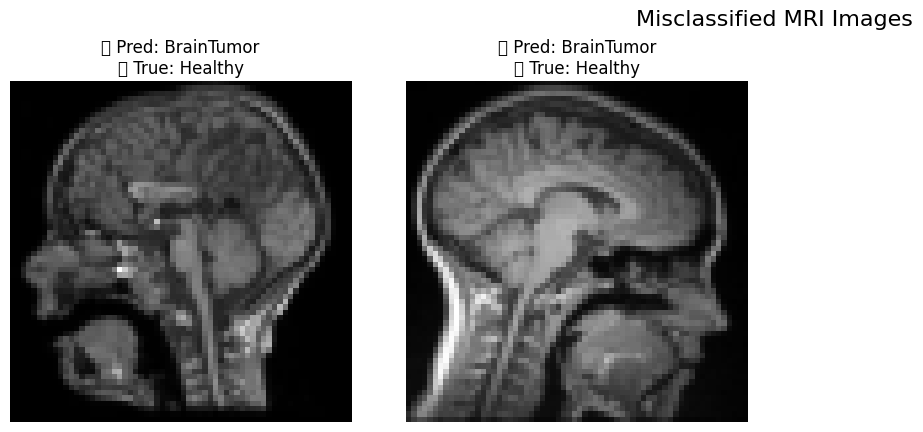

In [ ]:
plt.figure(figsize=(16, 8))
shown = 0
for idx in range(len(images)):
    if shown >= 8:
        break
    true_label = labels[idx].item()
    pred_label = predicted[idx].item()
    if true_label != pred_label:
        plt.subplot(2, 4, shown + 1)
        plt.imshow(denorm(images[idx]), cmap='gray')
        plt.title(f"❌ Pred: {class_names[pred_label]}\n✅ True: {class_names[true_label]}")
        plt.axis('off')
        shown += 1

plt.suptitle("Misclassified MRI Images", fontsize=16)
plt.tight_layout()
plt.show()


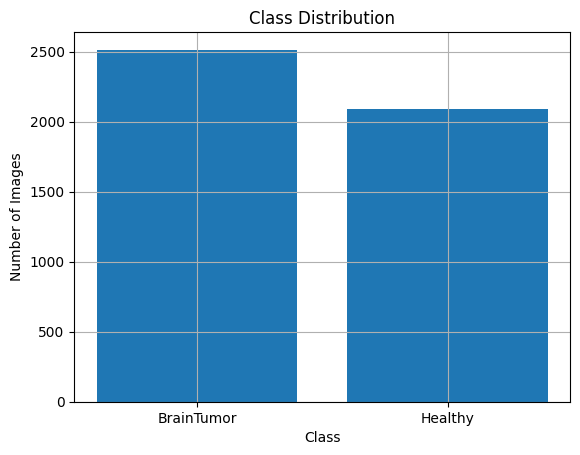

In [ ]:
import pandas as pd

# Count class occurrences
label_counts = pd.Series([label for _, label in dataset.samples]).value_counts()
plt.bar(dataset.class_to_idx.keys(), label_counts)
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.grid(True)
plt.show()


In [ ]:
plt.plot(range(1, num_epochs+1), loss_history, label='Loss')
plt.plot(range(1, num_epochs+1), acc_history, label='Accuracy')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'loss_history' is not defined

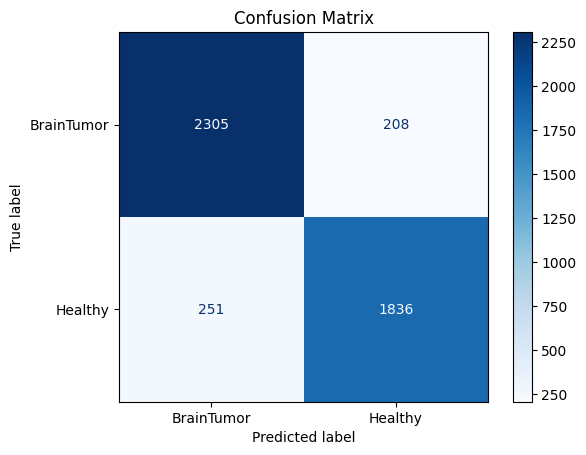

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


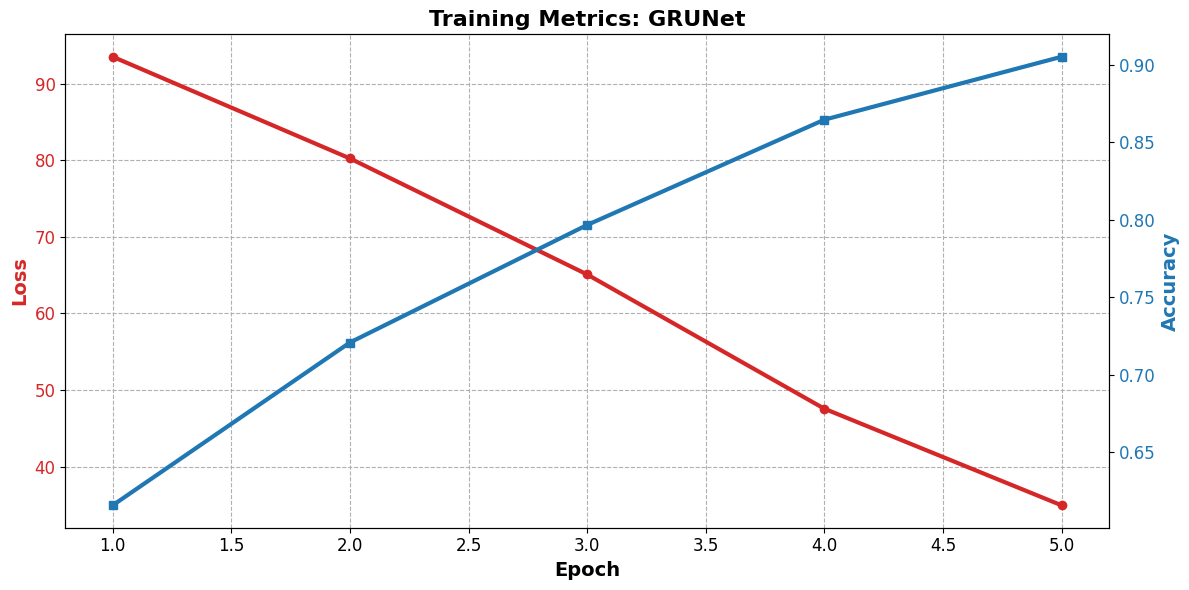

In [1]:
import matplotlib.pyplot as plt

# Actual training logs from your session
loss_history = [93.5190, 80.2415, 65.0866, 47.5541, 34.9400]
acc_history = [0.6159, 0.7209, 0.7967, 0.8646, 0.9052]

# Plot Loss and Accuracy on the same graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Loss (left y-axis)
color = 'tab:red'
ax1.set_xlabel('Epoch', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color=color, fontsize=14, fontweight='bold')
ax1.plot(range(1, len(loss_history)+1), loss_history, color=color, marker='o', linewidth=3, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(True, linestyle='--')

# Plot Accuracy (right y-axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color, fontsize=14, fontweight='bold')
ax2.plot(range(1, len(acc_history)+1), acc_history, color=color, marker='s', linewidth=3, label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

# Title
plt.title("Training Metrics: GRUNet", fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()
